In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
%matplotlib inline

from PIL import Image
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def prepare_dataframe(path):
    labels = os.listdir(path)
    
    df_dict = {}
    for label in labels:
        for jpg_file in os.listdir(f'{path}/{label}'):
            df_dict[f'{label}/{jpg_file}'] = label
    
    df = pd.DataFrame({'img_path': df_dict.keys(), 'label': df_dict.values()})
    
    return df

In [ ]:
file_path = 'dataset/Rice_Leaf_Diease/Rice_Leaf_Diease'

df = prepare_dataframe(f'{file_path}/train')
test = prepare_dataframe(f'{file_path}/test')
test['label'] = test['label'].apply(lambda x: '_'.join(x.lower().split()))

df['img_path'] = df['img_path'].apply(lambda x: file_path + '/train/' + x)
test['img_path'] = test['img_path'].apply(lambda x: file_path + '/test/' + x)

print('Train Shape:', df.shape)
print('Test Shape:', test.shape)

Train Shape: (15023, 2)
Test Shape: (3422, 2)


Use data from *Rice_Leaf_AUG* for training too.

In [ ]:
aug_path = 'dataset/Rice_Leaf_AUG/Rice_Leaf_AUG/'

aug_df = prepare_dataframe(aug_path)
aug_df['img_path'] = aug_df['img_path'].apply(lambda x: aug_path + x)
aug_df['label'] = aug_df['label'].apply(lambda x: '_'.join(x.lower().split()))
aug_df['label'] = aug_df['label'].replace({'narrow_brown_leaf_spot': 'narrow_brown_spot',
                                          'healthy_rice_leaf': 'healthy'})
print(aug_df.shape)

(11790, 2)


## Data Prep

In [9]:
aug_train, aug_test = train_test_split(aug_df, test_size=0.15, random_state=42)
combined_train = pd.concat([aug_train, df]).reset_index(drop=True)
test_df = pd.concat([aug_test, test]).reset_index(drop=True)

print(combined_train.shape, test_df.shape)

(25044, 2) (5191, 2)


In [10]:
train_df, val_df = train_test_split(combined_train, test_size=0.2, stratify=combined_train['label'])
pd.crosstab(train_df['label'], columns='N').sort_values('N')

col_0,N
label,
tungro,1392
neck_blast,1479
narrow_brown_spot,1776
bacterial_leaf_blight,1923
healthy,1938
rice_hispa,2050
brown_spot,2235
leaf_scald,2242
sheath_blight,2358


In [12]:
def downsampling_df(df, sampling_num):
    df_prep = pd.DataFrame(columns=df.columns)
    for label in train_df['label'].unique():
        filtered_df = train_df[train_df['label'] == label]
        if len(filtered_df) > sampling_num:
            filtered_df = filtered_df.sample(sampling_num)

        df_prep = pd.concat([df_prep, filtered_df], axis=0)

    return df_prep.reset_index(drop=True)


train_df = downsampling_df(train_df, 1500)
pd.crosstab(train_df['label'], columns='N')

col_0,N
label,
bacterial_leaf_blight,1500
brown_spot,1500
healthy,1500
leaf_blast,1500
leaf_scald,1500
narrow_brown_spot,1500
neck_blast,1479
rice_hispa,1500
sheath_blight,1500


In [13]:
print('Train_shape:', train_df.shape)
print('Validation shape:', val_df.shape)
print('Test shape:', test_df.shape)

Train_shape: (14871, 2)
Validation shape: (5009, 2)
Test shape: (5191, 2)


**Create directory structure for training YOLO**

In [14]:
for dir_type in ['train', 'val', 'test']:
    try:
        os.system(f'rm -rf rice_data/{dir_type}')
    except:
        pass
        
    for label in df['label'].unique():
        os.makedirs(f"rice_data/{dir_type}/{label}/")

In [15]:
def write_img_files(directory, df):    
    # resize to (500, 500)
    for i, row in tqdm(df.iterrows()):
        img_path = row['img_path']
        label = row['label']
        
        filename = img_path.split('/')[-1].replace(' ', '_')
        img = cv2.imread(img_path)
        img = cv2.resize(img, (320, 320))

        dest_path = f"{directory}/{label}/{filename}"
        cv2.imwrite(dest_path, img)


write_img_files('rice_data/train', train_df)
write_img_files('rice_data/val', val_df)
write_img_files('rice_data/test', test_df)

14871it [01:23, 177.69it/s]
5009it [00:27, 183.43it/s]
5191it [00:35, 145.11it/s]


## Overview

In [16]:
temp = train_df.groupby('label').agg({'img_path': 'first'}).reset_index()

plt.subplots(3, 4, figsize=(10, 6))
for i, row in temp.iterrows():
    plt.subplot(3, 4, i+1)

    img = plt.imread(row['img_path'])
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

## Model training
- YOLOv8

In [17]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')

results = model.train(data='rice_data', imgsz=320, batch=64, 
                      device='cpu', epochs=10,)
model.save('rice.pt')

New https://pypi.org/project/ultralytics/8.3.118 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.97 🚀 Python-3.12.7 torch-2.6.0 CPU (Apple M3 Pro)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=rice_data, epochs=10, time=None, patience=100, batch=64, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

train: Scanning /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/train... 14871 images, 0 corrupt: 100%|██████████| 14871/14871 [00:01<00:00, 9031.68it/s]


train: New cache created: /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/train.cache


val: Scanning /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/val... 5009 images, 0 corrupt: 100%|██████████| 5009/5009 [00:00<00:00, 9999.80it/s] 

val: New cache created: /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]

                   all       0.77      0.992

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:19<00:00,  2.00s/it]

                   all      0.849      0.994

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]

                   all      0.869      0.997

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]

                   all      0.903      0.997

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]

                   all      0.934      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]

                   all      0.927      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]

                   all      0.952          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]

                   all      0.958      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]

                   all      0.963          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G     0.1218         23        320: 100%|██████████| 233/233 [09:00<00:00,  2.32s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:18<00:00,  1.96s/it]

                   all      0.966          1

10 epochs completed in 1.706 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.12.7 torch-2.6.0 CPU (Apple M3 Pro)
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs


train: /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/train... found 14871 images in 10 classes ✅ 
val: /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/val... found 5009 images in 10 classes ✅ 
test: /Users/dinithalakminwickramasinghe/Development Files/FYP-Paddy-Disease-Treatment-Rover/Model_Training/rice_data/test... found 4946 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


                   all      0.966          1
Speed: 0.0ms preprocess, 13.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


In [29]:
result = model(test_df.iloc[0]['img_path'], verbose=False)
label_dict = result[0].names

traceback = {}
for key, val in label_dict.items():
    traceback[val] = key
    
print(traceback)

{'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5, 'neck_blast': 6, 'rice_hispa': 7, 'sheath_blight': 8, 'tungro': 9}


In [30]:
y_pred = []
for img in tqdm(test_df['img_path'].tolist()):
    result = model(img, device='cuda', verbose=False)
    y_pred.append(result[0].probs.top1)

100%|██████████| 5191/5191 [01:52<00:00, 45.95it/s]


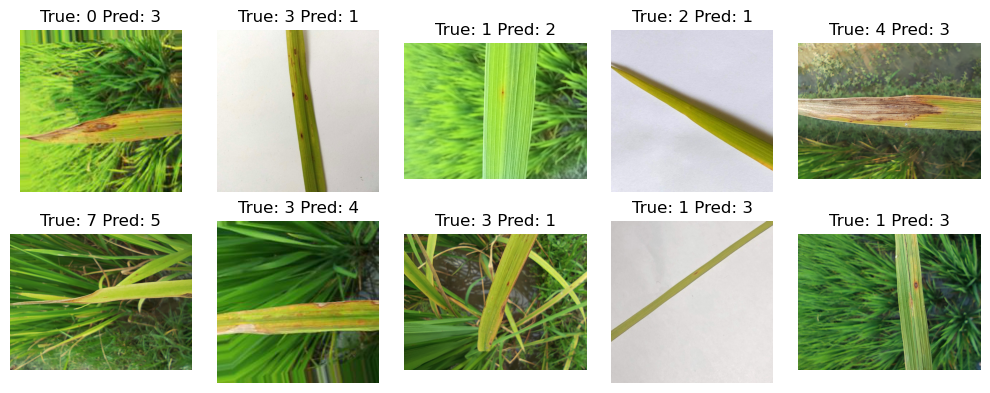

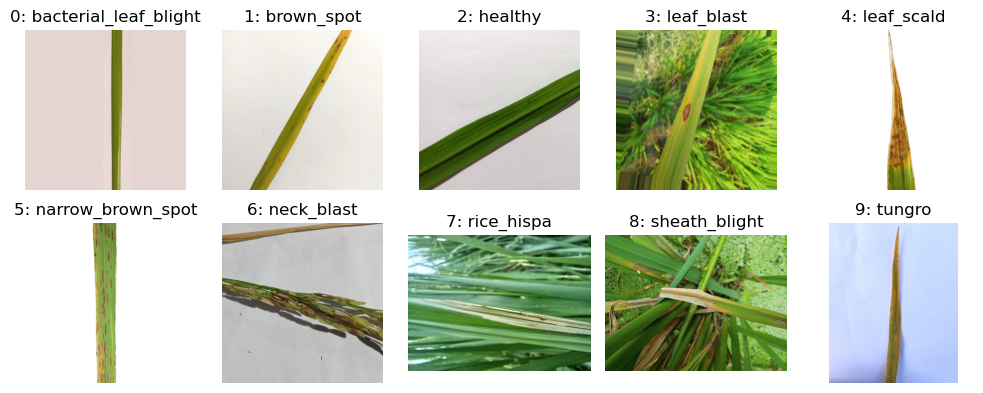

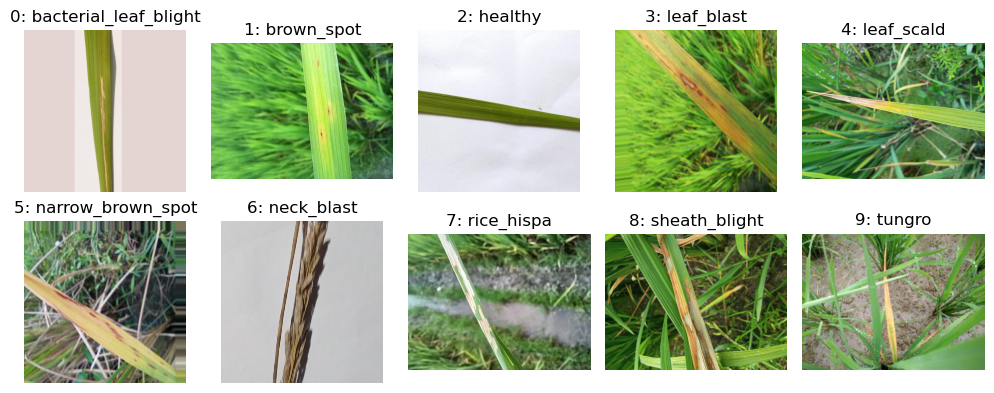

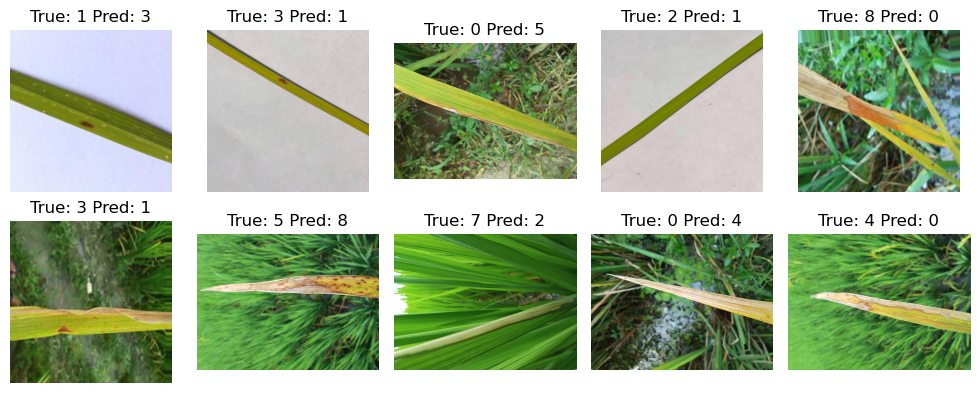

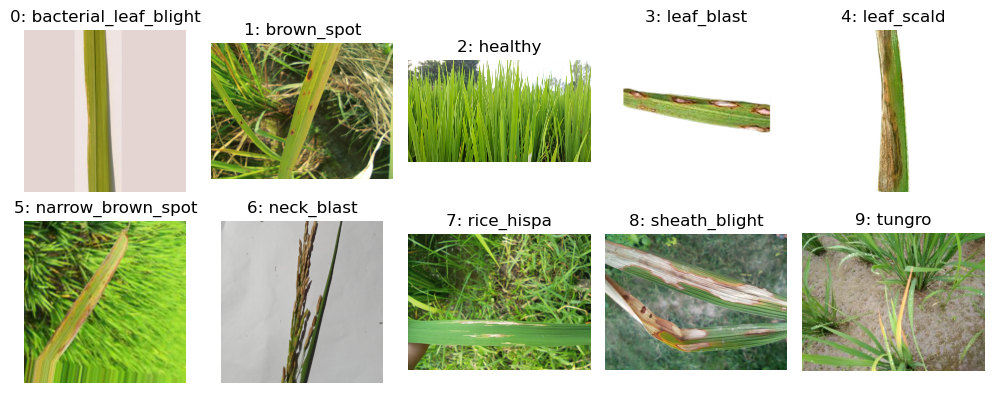

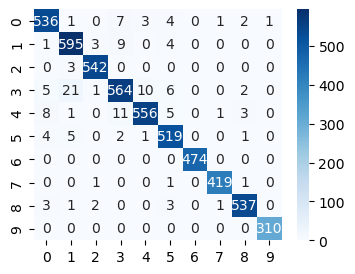

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.96      0.97      0.96       555
           brown_spot       0.95      0.97      0.96       612
              healthy       0.99      0.99      0.99       545
           leaf_blast       0.95      0.93      0.94       609
           leaf_scald       0.98      0.95      0.96       585
    narrow_brown_spot       0.96      0.98      0.97       532
           neck_blast       1.00      1.00      1.00       474
           rice_hispa       0.99      0.99      0.99       422
        sheath_blight       0.98      0.98      0.98       547
               tungro       1.00      1.00      1.00       310

             accuracy                           0.97      5191
            macro avg       0.98      0.98      0.98      5191
         weighted avg       0.97      0.97      0.97      5191



In [31]:
y_true = test_df['label'].map(traceback).tolist()

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', fmt='d')
plt.show()

# Show result and report
print(classification_report(y_true, y_pred, target_names=traceback.keys()))

## Error Analysis

In [32]:
inspect_df = test_df.copy()
inspect_df['label'] = inspect_df['label'].map(traceback)
inspect_df['pred'] = y_pred

false_pred = inspect_df[ inspect_df['label'] != inspect_df['pred'] ].sample(10).reset_index(drop=True)
plt.subplots(2, 5, figsize=(10, 4))
for i, row in false_pred.iterrows():
    plt.subplot(2, 5, i+1)
    img = plt.imread(row['img_path'])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"True: {row['label']} Pred: {row['pred']}")

plt.tight_layout()

In [33]:
true_label = test_df.groupby('label').sample(1).reset_index(drop=True).copy()
true_label['label_num'] = true_label['label'].map(traceback)

plt.subplots(2, 5, figsize=(10, 4))
for i, row in true_label.iterrows():
    plt.subplot(2, 5, i+1)
    img = plt.imread(row['img_path'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{row['label_num']}: {row['label']}")

plt.tight_layout()